# This notebook demos the FVM laplacian

Compute the Laplacian using combinations of the differential operators encountered so far

In [38]:
from dusk.script import *


@stencil
def laplacian_fvm(
    u: Field[Edge], 
    v: Field[Edge], 
    nx: Field[Edge], 
    ny: Field[Edge],
    uv_div: Field[Cell],
    uv_curl: Field[Vertex],
    grad_of_curl: Field[Edge],
    grad_of_div: Field[Edge],
    uv_nabla2: Field[Edge],
    L: Field[Edge],
    dualL: Field[Edge],
    A: Field[Cell],
    dualA: Field[Vertex],
    tangent_orientation: Field[Edge],
    edge_orientation_vertex: Field[Vertex > Edge],
    edge_orientation_cell: Field[Cell > Edge],
) -> None:

    with levels_upward as k:

        # compute curl (on vertices)
        uv_curl = sum_over(Vertex > Edge, (u*nx + v*ny) * dualL * edge_orientation_vertex) / dualA

        # compute divergence (on cells)
        uv_div = sum_over(Cell > Edge, (u*nx + v*ny) * L * edge_orientation_cell) / A

        # first term of of nabla2 (gradient of curl)
        grad_of_curl = sum_over(Edge > Vertex, uv_curl, weights=[-1., 1, ])*tangent_orientation/L        

        # second term of of nabla2 (gradient of divergence)
        grad_of_div = sum_over(Edge > Cell, uv_div, weights=[-1., 1, ])*tangent_orientation/dualL        

        # finalize nabla2 (difference between the two gradients)
        uv_nabla2 = grad_of_div - grad_of_curl


Then we can use dusk's Python API to convert the stencils to SIR. This API can also invoke dawn to compile SIR to C++:

In [39]:
from dusk.transpile import callables_to_pyast, pyast_to_sir, sir_to_cpp

with open("laplacian_fvm_cxx-naive.cpp", "w+") as f:
    f.write(sir_to_cpp(pyast_to_sir(callables_to_pyast([laplacian_fvm]))))

The generated C++ code also requires a driver which is already setup for this demo. With the driver code we can generate an executable `runner`:

In [54]:
!make

The runner is going to execute the Laplacian stencil. The divergence and curl are intermediary results this time around, and checked automatically. There is no need for you to specify anything, just execute the runner to see which quantities you got right!

In [55]:
!./runner 

mesh stats: #cells 1760 #nodes 940 #edges 2699
curl_uv L1: 0.001434, L2: 0.001863, Linf: 0.004384
which looks right! :)
div_uv L1: 0.011048, L2: 0.014044, Linf: 0.033851
which looks right! :)
nabal2_uv L1: 0.614767, L2: 0.830457, Linf: 2.901537


Besides ensuring the error norms L1, L2 and L infinity are small (they should all be well below 0.1), you can also have a look at the test function and its Laplacian by executing `checker.py laplacian`. You are free to also look at the `divergence` or `curl` computed above, by using `checker.py divergence` and `checker.py curl`. However, those are the same as the ones computed in the last exercise

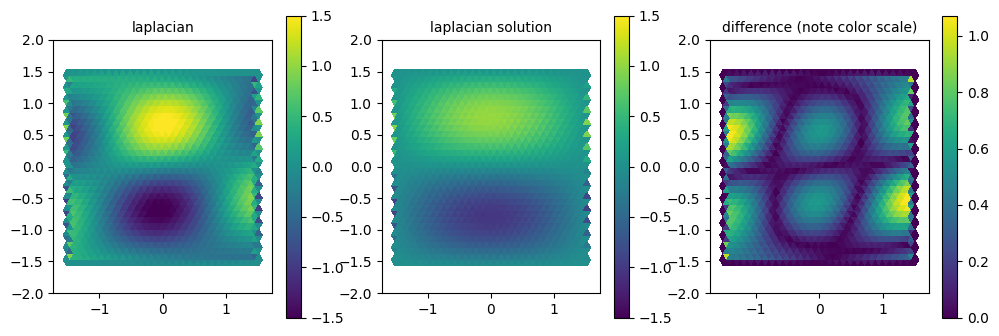

In [56]:
%run checker.py laplacian